In [9]:
#Import libraries
import numpy as np
import cv2
from matplotlib import pyplot as plt

#Convolution function
def convolve2d(image, kernel, stride):
  #flip the kernel horizontally and vertically
  kernel = np.flipud(np.fliplr(kernel))

  k_sizeX, k_sizeY = kernel.shape

  im_sizeX, im_sizeY = image.shape

  #Adding padding to the image
  padding = (k_sizeX-1)/2
  image = cv2.copyMakeBorder(image,int(padding),int(padding),int(padding),int(padding),
                             cv2.BORDER_CONSTANT, value = 0)

  #output image (convolved with image)
  output_height = int((im_sizeX-k_sizeX+2*padding)/stride)+1
  output_width = int((im_sizeY-k_sizeY+2*padding)/stride)+1
  output = np.zeros((output_height,output_width))
  
  for y in range(int(padding), im_sizeY+int(padding)-k_sizeY+1,stride):
    if y > im_sizeY-k_sizeY:
      break

    for x in range(int(padding), im_sizeX+int(padding)-k_sizeX+1,stride):
      if x > im_sizeX-k_sizeX:
        break

      output[int(x/stride),int(y/stride)] = (kernel * image[x:x+k_sizeX, y:y+k_sizeY]).sum()
      
  return output

In [10]:
#Blurring function
def Blurring(image):
  GaussianKernel = np.array([[1, 4, 7, 4, 1],
                            [4, 16, 26, 16, 4],
                            [7, 26, 41, 26, 7],
                            [4, 16, 26, 16, 4],
                            [1, 4, 7, 4, 1]])
  GaussianKernel = GaussianKernel * (1/273)
  #convolving the image with the gaussian kernel
  Blurred_image = convolve2d(image, GaussianKernel, 2)
  Blurred_image = NormalizingBack(Blurred_image)
  return Blurred_image

#Normalizing function to bring back the image into range 0 to 255
def NormalizingBack(image):
  MaximumPixel = np.max(image)
  Normalized_image = (image/MaximumPixel)*255
  return Normalized_image

In [11]:
#Applying Sobel
def ApplySobel(image):
  Sx = np.array([[-1, 0, 1],
                 [ -2, 0, 2],
                 [-1, 0, 1]])
  Gx = convolve2d(image,Sx,1)
  Gx = NormalizingBack(Gx)
  Sy = np.array([[-1, -2, -1],
                 [0, 0, 0],
                 [1, 2, 1]])
  Gy = convolve2d(image,Sy,1)
  Gy = NormalizingBack(Gy)
  return Gx,Gy

In [12]:
#Function to find the gradient magnitude and direction at each pixel
def GradientOperations(Gx,Gy):
  magnitude = np.sqrt(Gx**2+Gy**2)
  magnitude = NormalizingBack(magnitude)
  direction = np.arctan2(Gy,Gx)
  return magnitude, direction

In [13]:
#Function to suppress the pixels that are not the local maximum to 0
#and to make the local maxima 255
def NonMaxSuppression(magnitude,direction):
  rows,columns = magnitude.shape
  output = np.zeros((rows,columns))

  for i in range(1,rows-1):
    for j in range(1,columns-1):
      angle = direction[i,j]

      #Dividing the unit circle into 22.5 degrees angles to make sure to get all directions
      if(15*np.pi/8 <= angle < np.pi/8) or (7*np.pi/8 <= angle < 9*np.pi/8):
        if (magnitude[i,j] > magnitude[i,j+1]) and (magnitude[i,j] > magnitude[i,j-1]):
          output[i,j] = magnitude[i,j]
        else:
          output[i,j] = 0
      elif(np.pi/8 <= angle < 3*np.pi/8) or (9*np.pi/8 <= angle < 11*np.pi/8):
        if (magnitude[i,j] > magnitude[i-1,j+1]) and (magnitude[i,j] > magnitude[i+1,j-1]):
          output[i,j] = magnitude[i,j]
        else:
          output[i,j] = 0
      elif(3*np.pi/8 <= angle < 5*np.pi/8) or (11*np.pi/8 <= angle < 13*np.pi/8):
        if (magnitude[i,j] > magnitude[i-1,j]) and (magnitude[i,j] > magnitude[i+1,j]):
          output[i,j] = magnitude[i,j]
        else:
          output[i,j] = 0
      elif(5*np.pi/8 <= angle < 7*np.pi/8) or (13*np.pi/8 <= angle < 15*np.pi/8):
        if (magnitude[i,j] > magnitude[i-1,j-1]) and (magnitude[i,j] > magnitude[i+1,j+1]):
          output[i,j] = magnitude[i,j]
        else:
          output[i,j] = 0

  output = NormalizingBack(output)
  return output

In [14]:
#Ptile thresholding function to keep the edges above a threshold T
def PTileThresholding(image, P):
  rows,columns = image.shape
  output = np.zeros((rows,columns))
  images = []
  for P in Ps:
    #Mapping p to the desired threshold in the image
    T = int((100-P)*(np.max(image)-np.min(image))/100)
    output[image<T] = 0
    output[image >= T] = 255
    imagetoappend = np.copy(output)
    images.append(imagetoappend)
    EdgeCount = np.sum(output == 255)
    print(f"P = {P}%, Threshold = {T}, Edge Count = {EdgeCount}")
  return images

Reading file:  lenna.png
P = 10%, Threshold = 229, Edge Count = 17
P = 20%, Threshold = 204, Edge Count = 37
P = 30%, Threshold = 178, Edge Count = 88
P = 50%, Threshold = 127, Edge Count = 278
Reading file:  test3.jpg
P = 10%, Threshold = 229, Edge Count = 18
P = 20%, Threshold = 204, Edge Count = 79
P = 30%, Threshold = 178, Edge Count = 200
P = 50%, Threshold = 127, Edge Count = 676
Reading file:  test1.bmp
P = 10%, Threshold = 229, Edge Count = 707
P = 20%, Threshold = 204, Edge Count = 707
P = 30%, Threshold = 178, Edge Count = 707
P = 50%, Threshold = 127, Edge Count = 983
Reading file:  test2.bmp
P = 10%, Threshold = 229, Edge Count = 1134
P = 20%, Threshold = 204, Edge Count = 1134
P = 30%, Threshold = 178, Edge Count = 1276
P = 50%, Threshold = 127, Edge Count = 1734


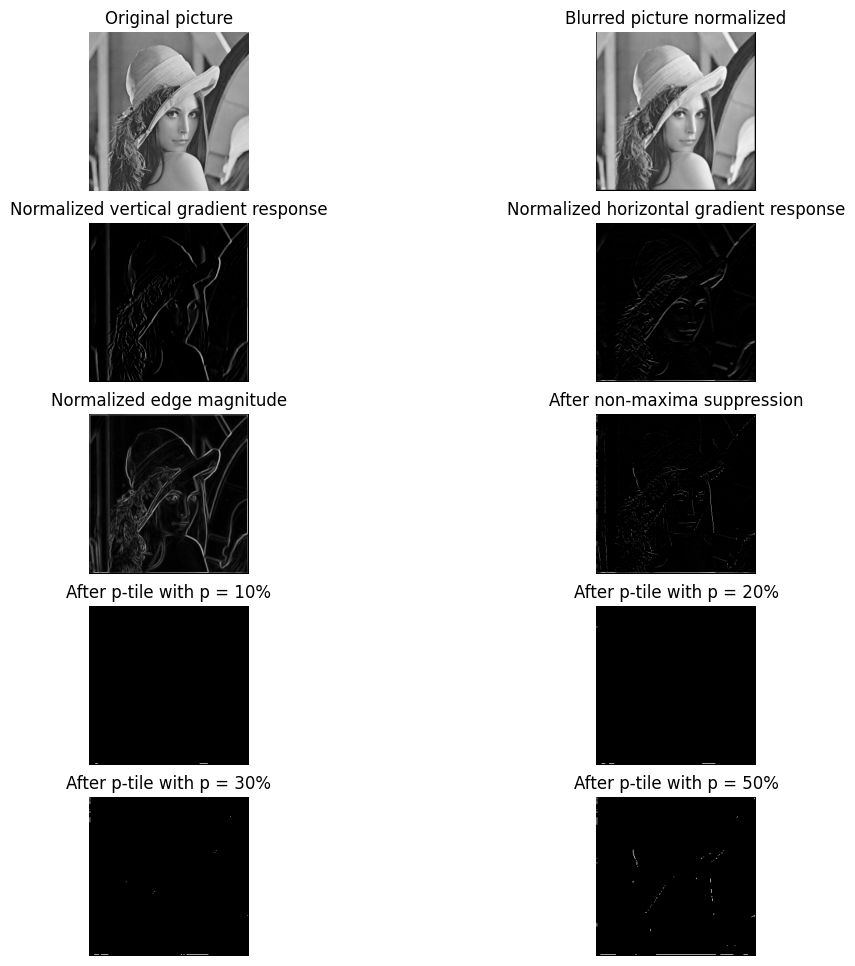

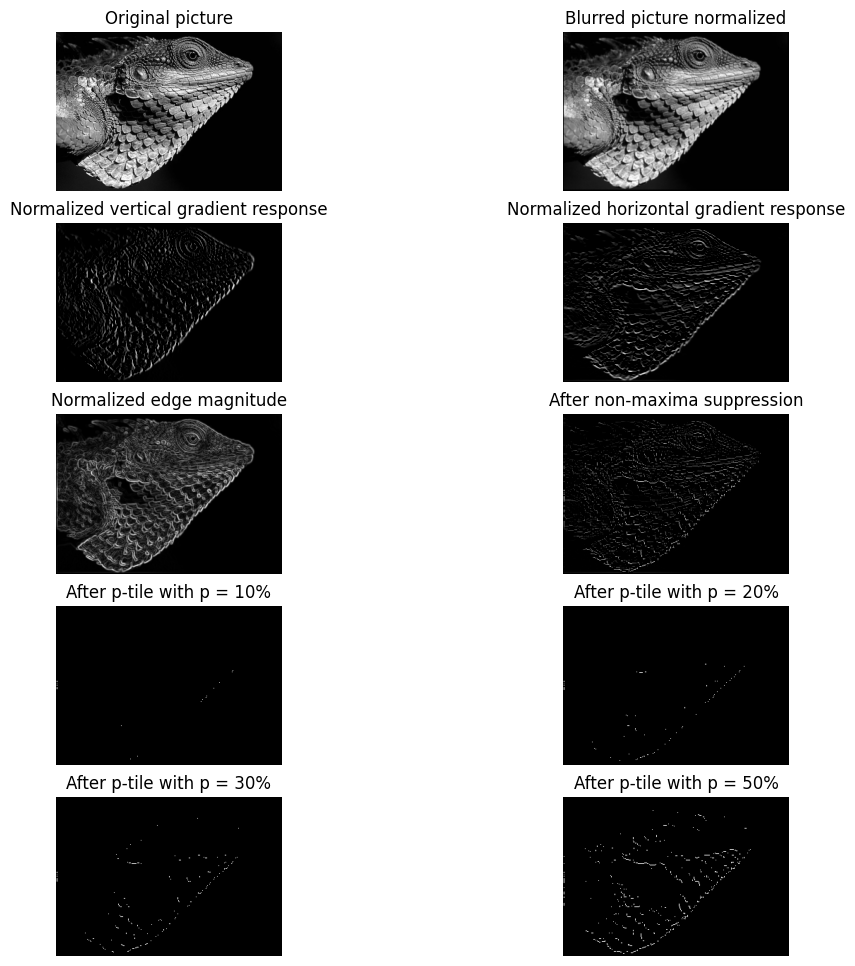

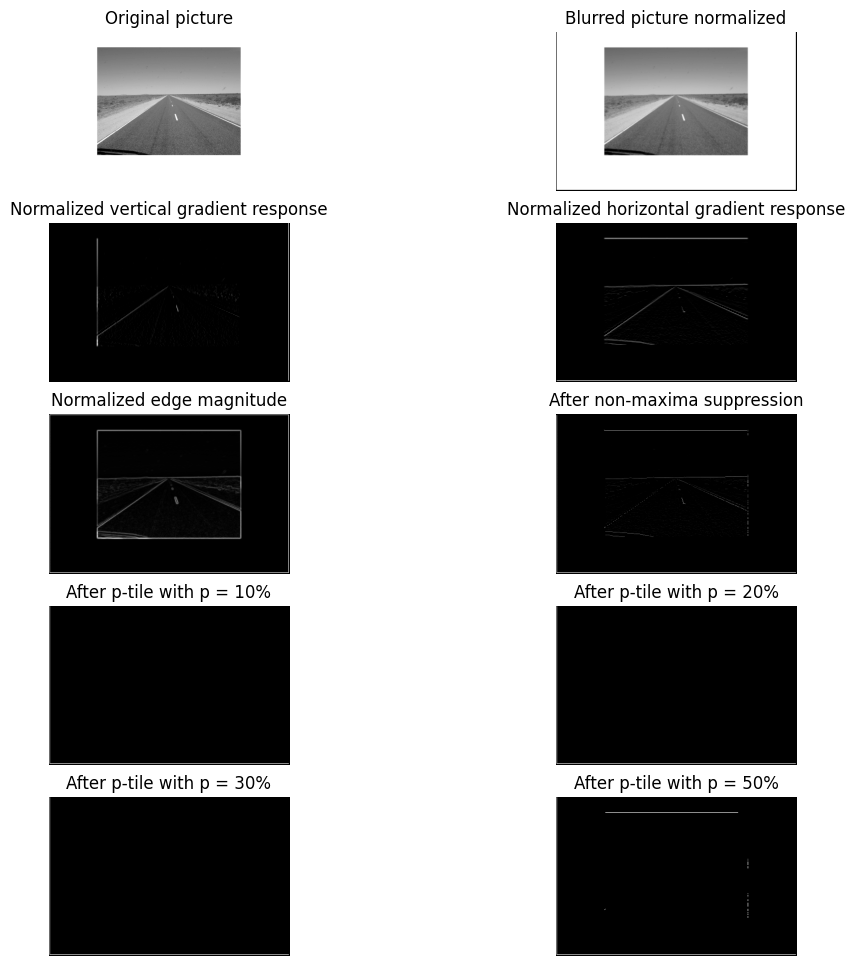

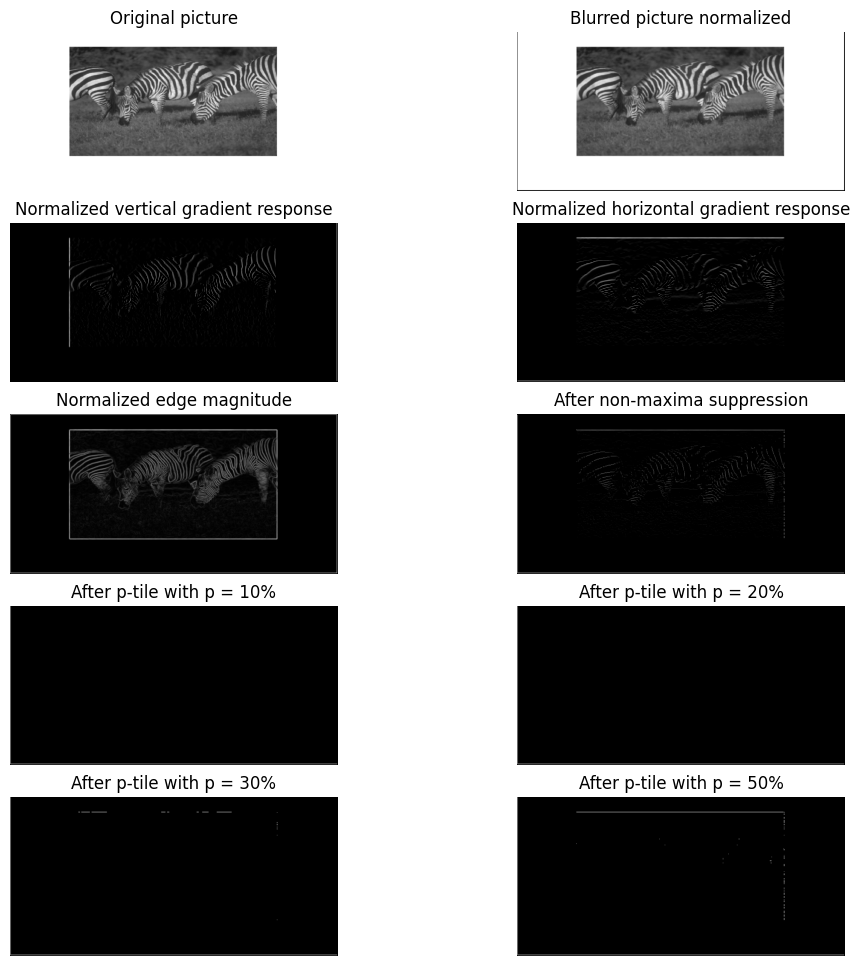

In [20]:
import os

image_files = os.listdir('Images')

# Loop over each file
for image_file in image_files:
    plt.figure()
    # Read the image
    print("Reading file: ", image_file)
    input_image = cv2.imread(os.path.join('Images', image_file))
    input_image = cv2.cvtColor(src=input_image, code=cv2.COLOR_BGR2GRAY)
    plt.subplot(5,2,1)
    plt.imshow(input_image, cmap='gray',vmin=0,vmax=255)
    plt.title("Original picture")
    plt.axis('off')
    fig = plt.gcf()
    fig.set_size_inches(12, 12)

    # Apply the CED pipeline
    Blurred_image = Blurring(input_image)
    Gx,Gy = ApplySobel(Blurred_image)
    GradientMagnitude , GradientDirection = GradientOperations(Gx,Gy)
    Suppressed_image = NonMaxSuppression(GradientMagnitude, GradientDirection)
    Ps = [10,20,30,50]
    ThresholdedImages = PTileThresholding(Suppressed_image,Ps)

    #Displaying the images
    plt.subplot(5,2,2)
    plt.imshow(Blurred_image, cmap='gray',vmin=0,vmax=255)
    plt.title("Blurred picture normalized")
    plt.axis('off')
    fig = plt.gcf()
    fig.set_size_inches(12, 12)

    plt.subplot(5,2,3)
    plt.imshow(Gx, cmap='gray',vmin=0,vmax=255)
    plt.title("Normalized vertical gradient response")
    plt.axis('off')
    fig = plt.gcf()
    fig.set_size_inches(12, 12)

    plt.subplot(5,2,4)
    plt.imshow(Gy, cmap='gray',vmin=0,vmax=255)
    plt.title("Normalized horizontal gradient response")
    plt.axis('off')
    fig = plt.gcf()
    fig.set_size_inches(12, 12)

    plt.subplot(5,2,5)
    plt.imshow(GradientMagnitude, cmap='gray',vmin=0,vmax=255)
    plt.title("Normalized edge magnitude")
    plt.axis('off')
    fig = plt.gcf()
    fig.set_size_inches(12, 12)

    plt.subplot(5,2,6)
    plt.imshow(Suppressed_image, cmap='gray',vmin=0,vmax=255)
    plt.title("After non-maxima suppression")
    plt.axis('off')
    fig = plt.gcf()
    fig.set_size_inches(12, 12)

    plt.subplot(5,2,7)
    plt.imshow(ThresholdedImages[0], cmap='gray',vmin=0,vmax=255)
    plt.title("After p-tile with p = 10%")
    plt.axis('off')
    fig = plt.gcf()
    fig.set_size_inches(12, 12)

    plt.subplot(5,2,8)
    plt.imshow(ThresholdedImages[1], cmap='gray',vmin=0,vmax=255)
    plt.title("After p-tile with p = 20%")
    plt.axis('off')
    fig = plt.gcf()
    fig.set_size_inches(12, 12)

    plt.subplot(5,2,9)
    plt.imshow(ThresholdedImages[2], cmap='gray',vmin=0,vmax=255)
    plt.title("After p-tile with p = 30%")
    plt.axis('off')
    fig = plt.gcf()
    fig.set_size_inches(12, 12)

    plt.subplot(5,2,10)
    plt.imshow(ThresholdedImages[3], cmap='gray',vmin=0,vmax=255)
    plt.title("After p-tile with p = 50%")
    plt.axis('off')
    fig = plt.gcf()
    fig.set_size_inches(12, 12)